In [1]:
import pandas as pd
import re
import random
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [13]:
# read dataset.csv
steam_review = pd.read_csv('dataset.csv',skiprows=lambda i: i > 0 and random.random() > 0.005)

steam_review

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,1
1,10,Counter-Strike,It's a very good game &lt;3 ^^,1,1
2,10,Counter-Strike,If you search a good game which need skills an...,1,0
3,10,Counter-Strike,Can shoot terrorists and be terrorist. Can pla...,1,1
4,10,Counter-Strike,Pretty awesome graphics but bad gameplay !,1,0
...,...,...,...,...,...
32141,99910,Puzzle Pirates,Puzzle Pirates is an excellent MMO puzzling ga...,1,1
32142,99910,Puzzle Pirates,I thought this would be terrible but now I see...,1,0
32143,99910,Puzzle Pirates,Fun game to play and it's free,1,0
32144,99910,Puzzle Pirates,I know I am not the first person to complain a...,-1,0


In [3]:
# 确保下载所需的 NLTK 数据
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('all')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/jinghao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinghao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jinghao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jinghao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/jinghao/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/jinghao/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron

In [4]:
# 检查数据是否包含缺失值
steam_review.isnull().sum()

app_id            0
app_name        898
review_text      38
review_score      0
review_votes      0
dtype: int64

In [6]:
# 查看app_name为空的行
steam_review[steam_review['app_id'] == 107800]

,app_id,app_name,review_text,review_score,review_votes
1028,107800,NaN,As side scrollers go I really enjoy this game....,1,0
1029,107800,NaN,Fun platformer with some nice tricks. Pretty s...,1,0
1030,107800,NaN,Amazing game! Worth every penny.,1,0
1031,107800,NaN,Good platformer. It's more puzzle driven than ...,1,0
1032,107800,NaN,You play as fat gordon freeman who got a job a...,1,0


In [14]:
def handle_missing_values(df):
    # 1. 用 app_id -> app_name 的映射填补缺失的 app_name
    app_name_map = df.dropna(subset=["app_name"]).drop_duplicates(subset=["app_id"])[["app_id", "app_name"]]
    app_name_dict = dict(zip(app_name_map["app_id"], app_name_map["app_name"]))

    df["app_name"] = df.apply(
        lambda row: app_name_dict.get(row["app_id"]) if pd.isna(row["app_name"]) else row["app_name"],
        axis=1
    )

    # 2. 删除仍然为空的 app_name
    df = df.dropna(subset=["app_name"])

    # 3. 删除 review_text 为空的行
    df = df.dropna(subset=["review_text"])

    return df

steam_review = handle_missing_values(steam_review)

# 检查处理后的数据
steam_review

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,1
1,10,Counter-Strike,It's a very good game &lt;3 ^^,1,1
2,10,Counter-Strike,If you search a good game which need skills an...,1,0
3,10,Counter-Strike,Can shoot terrorists and be terrorist. Can pla...,1,1
4,10,Counter-Strike,Pretty awesome graphics but bad gameplay !,1,0
...,...,...,...,...,...
32141,99910,Puzzle Pirates,Puzzle Pirates is an excellent MMO puzzling ga...,1,1
32142,99910,Puzzle Pirates,I thought this would be terrible but now I see...,1,0
32143,99910,Puzzle Pirates,Fun game to play and it's free,1,0
32144,99910,Puzzle Pirates,I know I am not the first person to complain a...,-1,0


In [15]:
# 转化review_text列为str
steam_review['review_text'] = steam_review['review_text'].astype(str)

# 将review_score中-1的值替换为0
steam_review['review_score'] = steam_review['review_score'].replace(-1, 0)

# 2. 去重
steam_review.drop_duplicates(subset=['app_id','review_text'], inplace=True)

# 3. 重置索引
steam_review.reset_index(drop=True, inplace=True)

In [16]:
# 匹配所有“爱心”表情符号
heart_pattern = r'[♥]'

# 找出包含爱心字符的行
contains_heart = steam_review[steam_review['review_text'].str.contains(heart_pattern, regex=True)]

# 显示结果
contains_heart


,app_id,app_name,review_text,review_score,review_votes
7,10,Counter-Strike,It was the best game ever made before valve ♥♥...,1,0
25,10,Counter-Strike,Counter-Strike: Global Offensive is the curren...,0,0
31,10,Counter-Strike,This is a good as it can be. Require skills an...,1,0
34,10,Counter-Strike,This is in my opinion one of the best games ev...,1,1
56,10090,Call of Duty: World at War,"♥♥♥♥ yeah ♥♥♥♥, 10/10 best game on internet ex...",1,1
...,...,...,...,...,...
26726,99300,Renegade Ops,Fun game. Would be a lot better if you weren't...,1,0
26731,9940,Blade Kitten,"If you like games that are anime as ♥♥♥♥, feat...",1,0
26736,99810,Bulletstorm,Couldn't play due to windows live ♥♥♥♥♥♥♥t.,0,0
26737,99810,Bulletstorm,GFWL bug fix wasn't horrible after a half hour...,0,1


In [17]:
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)

steam_review['review_text'] = steam_review.review_text.apply(replace_hearts_with_PAD)

In [19]:
steam_review

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,1
1,10,Counter-Strike,It's a very good game &lt;3 ^^,1,1
2,10,Counter-Strike,If you search a good game which need skills an...,1,0
3,10,Counter-Strike,Can shoot terrorists and be terrorist. Can pla...,1,1
4,10,Counter-Strike,Pretty awesome graphics but bad gameplay !,1,0
...,...,...,...,...,...
26750,99910,Puzzle Pirates,Puzzle Pirates is an excellent MMO puzzling ga...,1,1
26751,99910,Puzzle Pirates,I thought this would be terrible but now I see...,1,0
26752,99910,Puzzle Pirates,Fun game to play and it's free,1,0
26753,99910,Puzzle Pirates,I know I am not the first person to complain a...,0,0


In [21]:
# 统计每个 app_id 下各 review_score 的数量
score_counts = steam_review.groupby(['app_id', 'review_score']).size().unstack(fill_value=0)

# 计算总评论数和推荐比例
score_counts['total'] = score_counts.sum(axis=1)
score_counts['positive_ratio'] = score_counts.get(1, 0) / score_counts['total']

# 显示前几行结果
score_counts


review_score,0,1,total,positive_ratio
app_id,,,,
10,3,48,51,0.941176
20,1,10,11,0.909091
30,1,4,5,0.800000
40,0,3,3,1.000000
50,0,9,9,1.000000
...,...,...,...,...
556340,0,1,1,1.000000
557190,0,1,1,1.000000
559010,0,1,1,1.000000


In [11]:
def clean_text_for_transformer(text):
    
    # 1. 去除 HTML 标签
    text = re.sub(r'<.*?>', ' ', text)
    
    # 2. 去除 URL
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 3. 去除多余空格、换行、制表符
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# 5. 应用清洗函数
steam_review['cleaned_text'] = steam_review['review_text'].apply(clean_text_for_transformer)

In [12]:
steam_review

,app_id,app_name,review_text,review_score,review_votes,cleaned_text
0,10,Counter-Strike,1st Game in Life Ever Played :P Awsome in Steam,1,0,1st Game in Life Ever Played :P Awsome in Steam
1,10,Counter-Strike,Respect game),1,0,Respect game)
2,10,Counter-Strike,played just a little. it's ok,1,1,played just a little. it's ok
3,10,Counter-Strike,"Better than source, or GO... &lt;3 1.6!!! lite...",1,1,"Better than source, or GO... &lt;3 1.6!!! lite..."
4,10,Counter-Strike,This game sucks.,1,0,This game sucks.
...,...,...,...,...,...,...
26466,99910,Puzzle Pirates,best game in this world or any other BAR NONE!,1,0,best game in this world or any other BAR NONE!
26467,99910,Puzzle Pirates,One of the most addicting mmo i have played. 1...,1,0,One of the most addicting mmo i have played. 1...
26468,99910,Puzzle Pirates,do you like puzzle games? play this do you lik...,1,0,do you like puzzle games? play this do you lik...
26469,99910,Puzzle Pirates,i been playing this since i was a kid,1,0,i been playing this since i was a kid


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

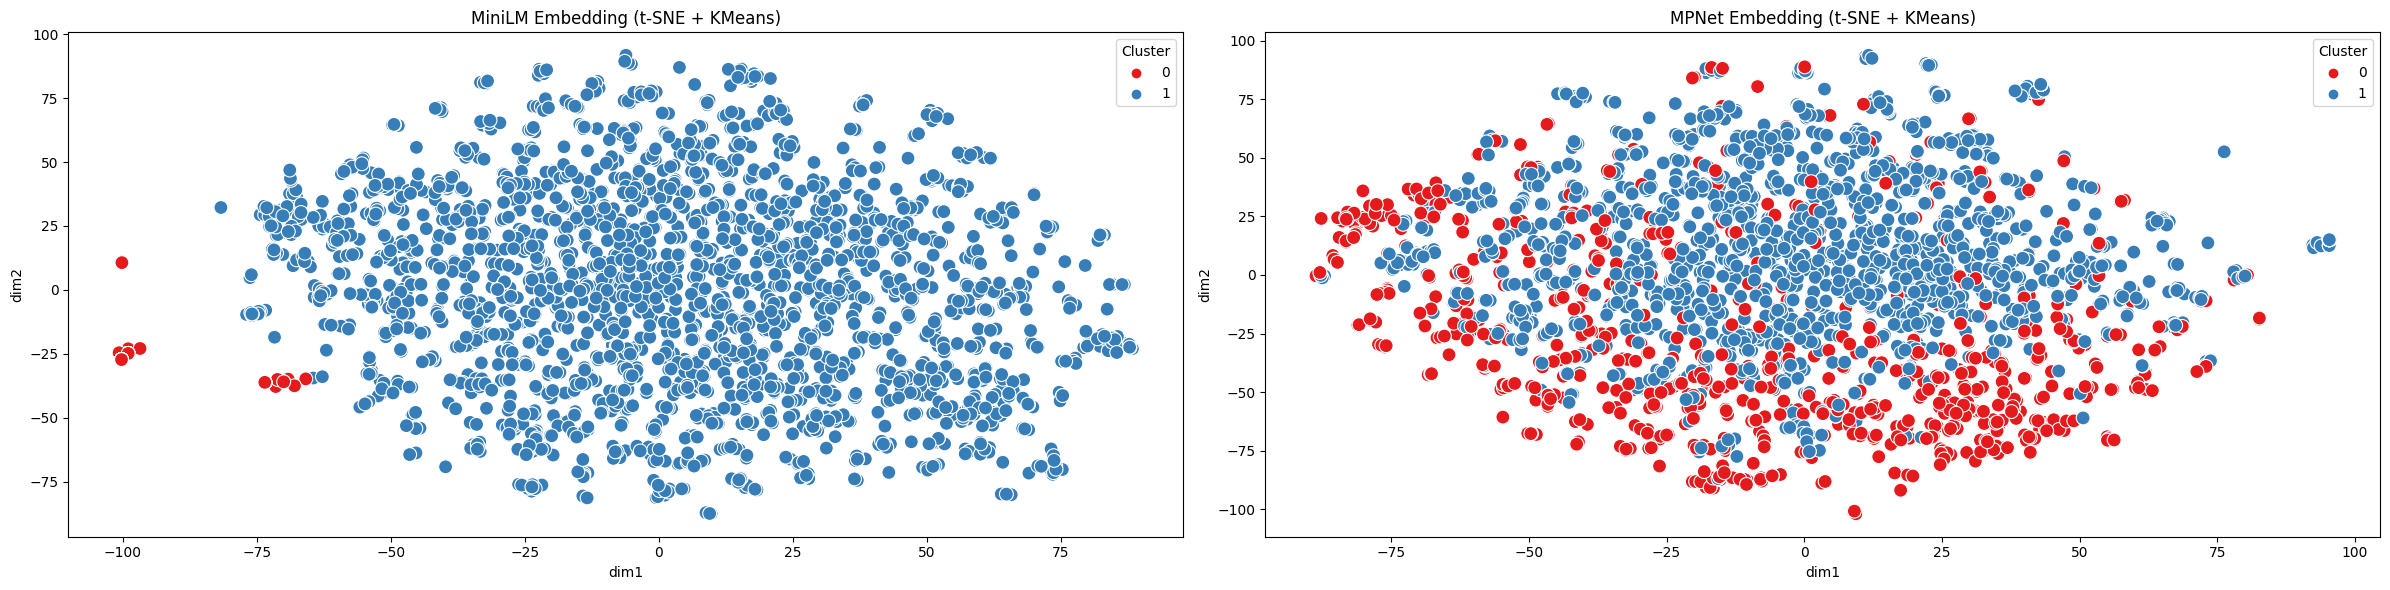

In [90]:
# 准备使用的 SentenceTransformer 模型列表
model_names = {
    "MiniLM": "all-MiniLM-L6-v2",
    "MPNet": "all-mpnet-base-v2"
}

# 存储结果用
embeddings_dict = {}

# 生成不同模型的嵌入
for label, model_name in model_names.items():
    model = SentenceTransformer(model_name)
    embeddings = model.encode(steam_review["cleaned_text"].tolist(), show_progress_bar=True)
    embeddings_dict[label] = embeddings

# 降维 + 可视化
fig, axes = plt.subplots(1, len(embeddings_dict), figsize=(12 * len(embeddings_dict), 6))

for i, (label, embed) in enumerate(embeddings_dict.items()):
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    X_2d = tsne.fit_transform(embed)

    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(embed)

    df_plot = pd.DataFrame(X_2d, columns=["dim1", "dim2"])
    df_plot["cluster"] = clusters
    df_plot["review"] = steam_review["review_text"]

    sns.scatterplot(
        x="dim1", y="dim2", hue="cluster", data=df_plot, ax=axes[i], palette="Set1", s=100
    )
    axes[i].set_title(f"{label} Embedding (t-SNE + KMeans)")
    axes[i].legend(title="Cluster")

plt.tight_layout()
plt.show()

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

准确率: 87.57%
分类报告:
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       102
           1       0.88      0.98      0.93       469

    accuracy                           0.88       571
   macro avg       0.84      0.69      0.74       571
weighted avg       0.87      0.88      0.86       571



/Users/jinghao/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghao/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghao/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghao/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghao/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38598 (\N{CJK

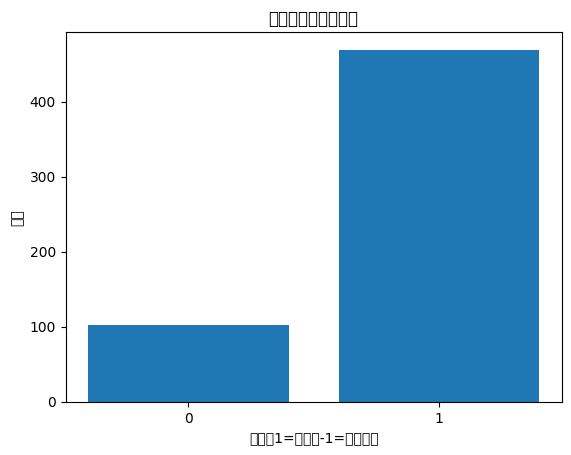

In [91]:
# 使用 SentenceTransformer 生成句子向量
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(steam_review['cleaned_text'].tolist(), show_progress_bar=True)

# 创建特征矩阵 X 和标签 y
X = np.array(embeddings)
y = steam_review['review_score'].values  # 假设是 0 / 1 二分类

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练分类模型（逻辑回归）
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 预测
y_pred = clf.predict(X_test)

# 输出评估结果
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 打印结果
print(f"准确率: {accuracy:.2%}")
print("分类报告:")
print(report)

# 可视化（选做）：绘制类分布
labels, counts = np.unique(y_test, return_counts=True)
plt.bar(labels, counts)
plt.xticks(labels)
plt.title("测试集实际标签分布")
plt.xlabel("标签（1=推荐，-1=不推荐）")
plt.ylabel("数量")
plt.show()
